In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, WeightedRandomSampler
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data.dataset import random_split

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics

from keras.utils.np_utils import to_categorical  

from torchsummary import summary

from torch.optim import lr_scheduler

from sklearn.preprocessing import StandardScaler

import time
import copy

In [2]:
# Enable gpu support
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Data extraction and preprocessing

In [3]:
data = pd.read_csv('data/train.csv')


In [4]:
display(data.head())
data.shape

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


(28709, 2)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28709 entries, 0 to 28708
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  28709 non-null  int64 
 1   pixels   28709 non-null  object
dtypes: int64(1), object(1)
memory usage: 448.7+ KB


In [6]:
X = np.array([
              [i for i in map(int, row)] for row 
              in map(str.split, data['pixels'])
      ]).reshape((-1, 48, 48))

In [7]:
X

array([[[ 70,  80,  82, ...,  52,  43,  41],
        [ 65,  61,  58, ...,  56,  52,  44],
        [ 50,  43,  54, ...,  49,  56,  47],
        ...,
        [ 91,  65,  42, ...,  72,  56,  43],
        [ 77,  82,  79, ..., 105,  70,  46],
        [ 77,  72,  84, ..., 106, 109,  82]],

       [[151, 150, 147, ..., 129, 140, 120],
        [151, 149, 149, ..., 122, 141, 137],
        [151, 151, 156, ..., 109, 123, 146],
        ...,
        [188, 188, 121, ..., 185, 185, 186],
        [188, 187, 196, ..., 186, 182, 187],
        [186, 184, 185, ..., 193, 183, 184]],

       [[231, 212, 156, ...,  44,  27,  16],
        [229, 175, 148, ...,  27,  35,  27],
        [214, 156, 157, ...,  28,  22,  28],
        ...,
        [241, 245, 250, ...,  57, 101, 146],
        [246, 250, 252, ...,  78, 105, 162],
        [250, 251, 250, ...,  88, 110, 152]],

       ...,

       [[ 74,  81,  87, ..., 189, 191, 192],
        [ 78,  82,  89, ..., 185, 189, 193],
        [ 81,  86,  94, ..., 176, 185, 193

In [8]:
X.shape

(28709, 48, 48)

In [9]:
y = data['emotion']
display(y.value_counts())
y = y.values

3    7215
6    4965
4    4830
2    4097
0    3995
5    3171
1     436
Name: emotion, dtype: int64

# Dataset

In [10]:
class EmotionsDataset(Dataset):
  def __init__(self, X, y, transform=None):
    self.transform = transform

    self.y = y

    self.X_tensor = torch.from_numpy(X).float().to(device).unsqueeze(1)
    self.y_tensor = torch.from_numpy(to_categorical(y, num_classes=7)).float().to(device)
  
  def __len__(self):
    return len(self.y_tensor)
  
  def __getitem__(self, index):
    X, y = self.X_tensor[index], self.y_tensor[index]

    if self.transform:
      X = self.transform(X)

    return X, y

# Augmentation

In [11]:
transform = transforms.Compose([
      transforms.RandomHorizontalFlip(),
      transforms.RandomAffine(degrees=(-15, 15), translate=(0.01, 0.15)),
      transforms.RandomPerspective(distortion_scale=0.35),
    ])

# Data visualisation

In [12]:
target_names = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral',
}

In [13]:
def plot_images(X, y, transform=None, classes=7, columns=5):
  _X = np.zeros((classes * columns, 48, 48))
  _y = []
  
  X, y = copy.deepcopy(X), copy.deepcopy(y)

  if transform:
    data_loader = DataLoader(EmotionsDataset(X, y, transform), batch_size=2048)

    X, y = next(iter(data_loader))

    X = X.squeeze(1).cpu()
    y = np.argmax(y.cpu(), axis=1)


  for label in range(classes):
    mask = (y == label)
    _X[columns * label : columns * label + columns] = X[mask, :][:columns]
    _y.extend([label] * columns)

  _, axes = plt.subplots(nrows=classes, ncols=columns, figsize=(15, 15))
  for ax, image, label in zip(axes.flatten(), _X, _y):
      ax.set_xticks([])
      ax.set_yticks([])
      ax.imshow(image, cmap=plt.cm.gist_gray)
      ax.set_title(target_names[label])

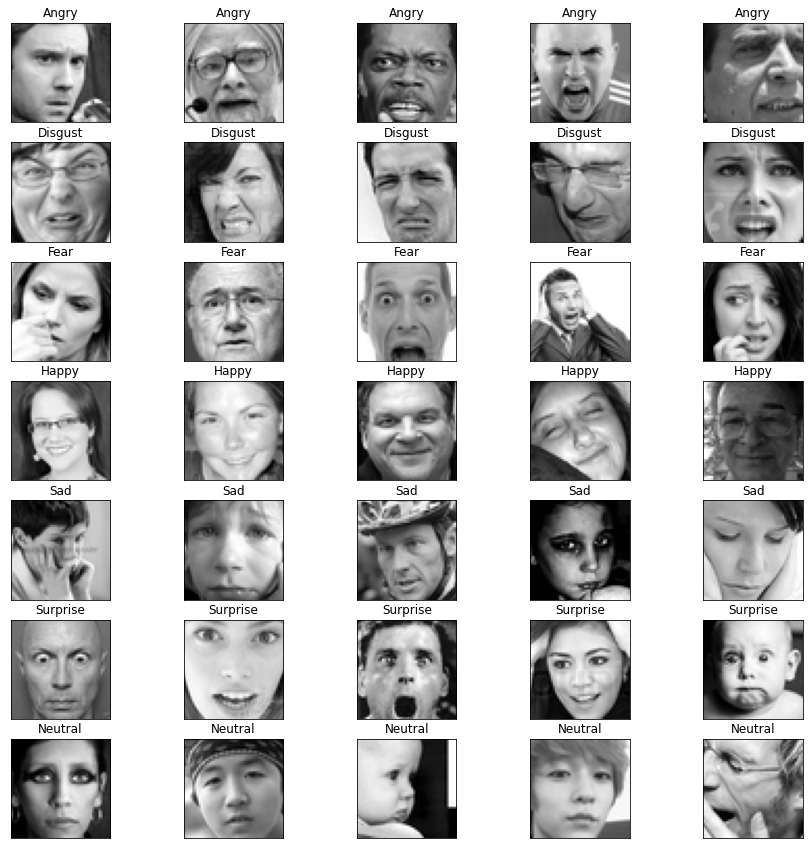

In [14]:
plot_images(X, y)

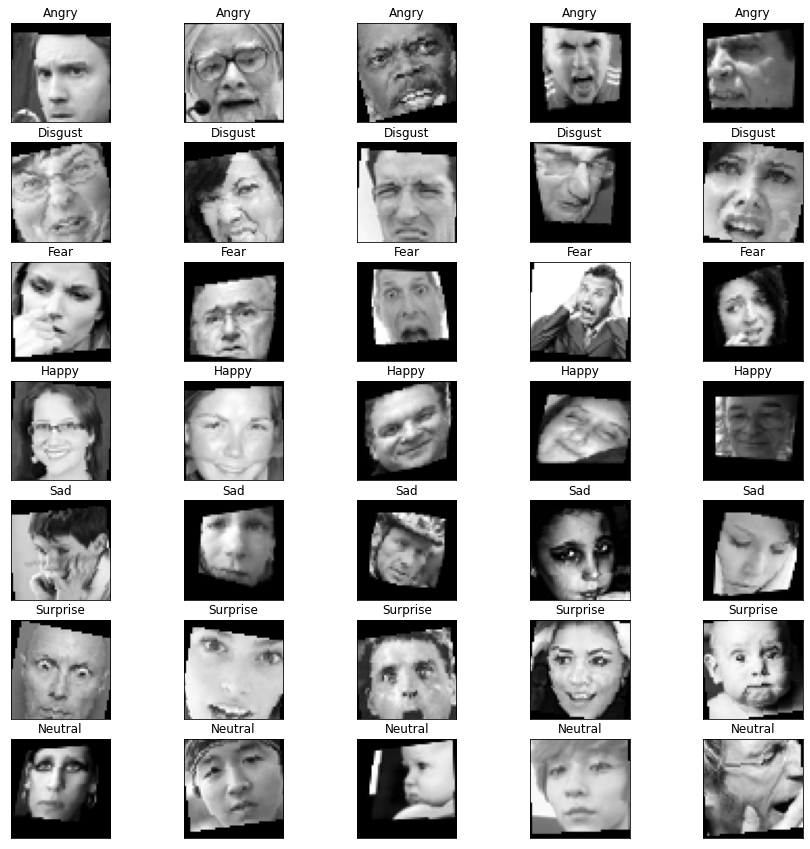

In [15]:
plot_images(X, y, transform)

# Augmentation expirements

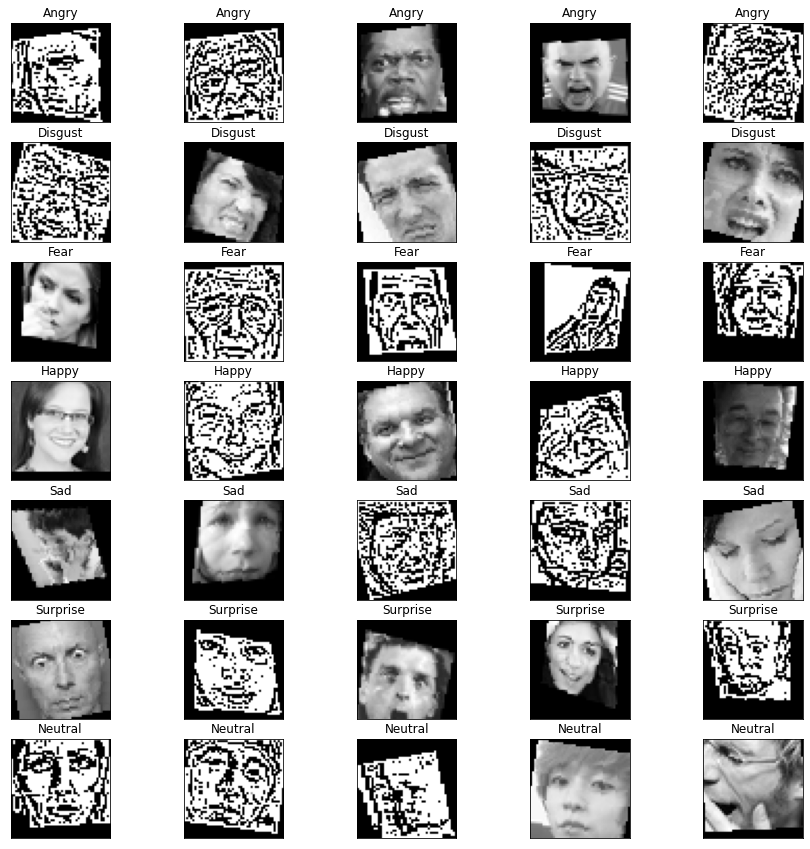

In [19]:
_transform = transforms.Compose([
      transforms.RandomHorizontalFlip(),
      transforms.RandomPerspective(distortion_scale=0.35),
      transforms.RandomAffine(degrees=(-15, 15), translate=(0.01, 0.15)),
      transforms.RandomAdjustSharpness(sharpness_factor=150)
    ])

plot_images(X, y, _transform)

# Plots

In [35]:
def plot_confusin_matrix(y_real, y_test):
  confusion_matrix = metrics.confusion_matrix(y_real, y_test)
  sns.heatmap(confusion_matrix, center=0, cmap='PiYG', annot=True)

  plt.show()

In [36]:
def plot_loss(train_loss, test_loss):
  x = [i for i in range(1, len(train_loss) + 1)]

  plt.plot(x, train_loss, label='train')
  plt.plot(x, test_loss, label='test')
  
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.show()

In [37]:
def plot_accuracy(train_accuracies, test_accuracies, step):
  x = [i for i in range(1, step * len(train_accuracies) + 1, step)]

  plt.plot(x, train_accuracies, label='train')
  plt.plot(x, test_accuracies, label='validation')

  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.show()

# Models

In [27]:
class Net(nn.Module):
  def __init__(self, backbone):
    super(Net, self).__init__()
    
    # last layer
    backbone.fc = nn.Linear(backbone.fc.in_features, 7, bias=True)

    self.model = nn.Sequential(
        # mapping grayscale pictures to 3 channels
        nn.Conv2d(1, 3, 1),
        backbone
    )

    # for param in self.model[1].parameters():
    #   param.requires_grad = False

  def forward(self, x):
    return self.model(x)

In [28]:
# Testing model
def test_model(model, test_loader, criterion=None, return_predictions=False):
    predictions = []
    labels = []
    loss_sum = 0.

    model.eval()
    
    for images, y in test_loader: 
      with torch.no_grad(): 
        outputs = model(images)

        if criterion:
          loss_sum += criterion(outputs, y)

        predictions += torch.argmax(outputs.data, axis=1).cpu()
        labels += torch.argmax(y.data, axis=1).cpu()
    
    model.train()
    
    d = {}

    d['accuracy'] = metrics.accuracy_score(labels, predictions)

    if return_predictions:
      d['predictions'] = predictions
    
    if criterion:
      d['loss'] = (loss_sum / len(test_loader)).cpu()
    
    return d

In [29]:
# Training model
def train_model(model, criterion, optimizer, scheduler, train_loader, test_loader,
                epochs, test_step):
    print('\n* Model training * ')

    train_accuracies = []
    test_accuracies = []

    train_losses, test_losses = [], []
    
    model.train()

    for epoch in range(epochs):
        print(f'\t* epoch #{epoch + 1}')
        for batch, (images, labels) in enumerate(train_loader):
          
          optimizer.zero_grad()
          
          # forward
          outputs = model(images)
          loss = criterion(outputs, labels)

          # backward
          loss.backward()

          optimizer.step()

        scheduler.step()

        # validation
        if epoch % test_step == 0:
          train_dict = test_model(model, train_loader, criterion=criterion)
          train_accuracies.append(train_dict['accuracy'])
          train_losses.append(train_dict['loss'])

          test_dict = test_model(model, test_loader, criterion=criterion)
          test_accuracies.append(test_dict['accuracy'])
          test_losses.append(test_dict['loss'])

          print(test_dict['accuracy'])
          # scheduler.step(accuracy)

    return {
        'train_accuracies': train_accuracies, 
        'test_accuracies': test_accuracies, 
        'train_losses': train_losses,
        'test_losses': test_losses
        }

In [32]:
def run_pipeline(
    X,
    y,
    model=models.resnet18(pretrained=True), 
    batch_size=2048,
    lr=0.001,
    epochs=1,
    transform=None,
    test_step=1,
    step_size=25,
    gamma=1,
    show_summary=False,
    random_state=42):
  
    # Reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(random_state)
    torch.cuda.manual_seed_all(random_state)
    
    # Data splitting
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=random_state
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_test, y_test, test_size=0.5, stratify=y_test, random_state=random_state
    )

    # Scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train.reshape(X_train.shape[0], 48 * 48)).reshape(X_train.shape[0], 48, 48)
    X_test = scaler.transform(X_test.reshape(X_test.shape[0], 48 * 48)).reshape(X_test.shape[0], 48, 48)
    X_val = scaler.transform(X_val.reshape(X_val.shape[0], 48 * 48)).reshape(X_val.shape[0], 48, 48)

    # Datasets
    train = EmotionsDataset(X_train, y_train, transform)
    val = EmotionsDataset(X_val, y_val)
    test = EmotionsDataset(X_test, y_test)

    # Sampler
    counts = np.unique(y_train, return_counts=True)[1]
    class_weights = np.power(counts, -1, dtype=float)

    sample_weights = [class_weights[label] for i, label in enumerate(y_train)]

    sampler = WeightedRandomSampler(sample_weights, 
                                num_samples=len(sample_weights),
                                replacement=True)

    # DataLoaders
    train_loader = DataLoader(train,
                              batch_size=batch_size,
                              sampler=sampler,
                              drop_last=True)
    val_loader = DataLoader(val,
                            batch_size=batch_size,
                            shuffle=False)
    test_loader = DataLoader(test,
                             batch_size=batch_size,
                             shuffle=False)

    # Model
    net = Net(backbone=model).float().to(device)
    
    # Model summary
    if show_summary:
        summary(net, (1, 48, 48))

    # Loss
    error=nn.CrossEntropyLoss()

    # Optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    # LR scheduler
    scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    # scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'max')

    # Training
    train_results = train_model(net, error, optimizer, scheduler, 
                                train_loader, val_loader, epochs, test_step)
    # Testing
    test_results = test_model(net, test_loader, return_predictions=True)
    print('Accuracy: ', test_results['accuracy'])

    # Plots
    plot_confusin_matrix(y_test, test_results['predictions'])
    plot_loss(train_results['train_losses'], train_results['test_losses'])
    plot_accuracy(train_results['train_accuracies'], train_results['test_accuracies'],
                  test_step)

    return train_results


* Model training * 
	* epoch #1
0.44165795889933823
	* epoch #2
0.4872866597004528
	* epoch #3
0.5343086032741206
	* epoch #4
0.5520724486241727
	* epoch #5
0.5489376523859283
	* epoch #6
0.5628700801114594
	* epoch #7
0.566004876349704
	* epoch #8
0.5903866248693835
	* epoch #9
0.5865552072448624
	* epoch #10
0.5928247997213515
Accuracy:  0.5802856147683734


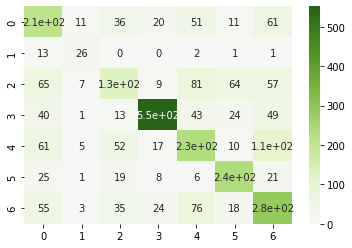

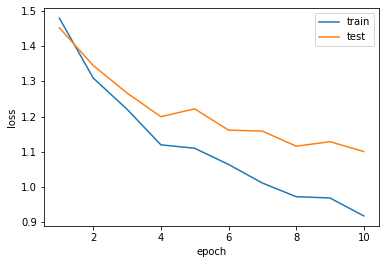

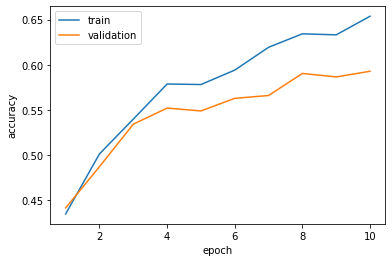

In [40]:
results = run_pipeline(X, y, model=models.resnet18(pretrained=True),
             epochs=10, batch_size=32, transform=transform, lr=10e-5, test_step=1,
             step_size=20, gamma=1)

# Some thoughts about project improvements.

Firstly, we need to specify much larger epoch rate (in this work it's not quite enough, due to the power and time limitations).<br>
Inception model is not used because image size is too small for that model (MaxPool2d layers reduce our image size too much).<br>
Considered models have their own traits & features, but for our task their behaviour tends to be almost the same. <br><br>
In out dataset we've got a class imbalance:<br>
7215 images for emotion "happy" (class 3)<br>
436 images for emotion "disgust" (class 1)<br>
~3000-5000 for other emotions
<br><br>
To overcome imbalance we used oversampling via WeightedRandomSampler <br><br>

# Conlusions
During this project, i have got better understanding of Tensorflow, Keras (initially used it for current project and coded a simple model via it) and PyTorch (switched to PyTorch afterwards). In the process of completing study, I get acquainted with Google Colaboratory, different neural networks, aspecially with classifiers with backbone architecture such as ResNet, EfficientNet, Inception & GoggleNet. Learned terminology, built models, trained them and evaluated on test data, suggested base improvements & thoughts.